In [16]:
# add slope 
import utm
import os
import pandas as pd
# https://github.com/Turbo87/utm
#The syntax is utm.from_latlon(LATITUDE, LONGITUDE).
#The return has the form (EASTING, NORTHING, ZONE_NUMBER, ZONE_LETTER).
#e, n , zone, letter= utm.from_latlon(lat, lon)

In [17]:
# Specify the path to the folder
folder_path = "../out"
root_path = '/gpfs/data1/vclgp/xiongl/IS2global/data/h3/atl08/shots_hex'
o_path = "../tmp"
# Use os.listdir() to get a list of all files in the folder
# Get a list of all files in the folder
files = [file for file in os.listdir(folder_path) 
         if os.path.isfile(os.path.join(folder_path, file))]
files[1]

'838386fffffffff.parquet'

In [18]:
df = pd.read_parquet(os.path.join(folder_path, files[10]))
df.columns.values

array(['land_segments/rgt', 'land_segments/segment_id_beg',
       'land_segments/segment_id_end', 'root_beam', 'root_file',
       'land_segments/canopy/h_canopy_20m_000',
       'land_segments/canopy/h_canopy_20m_001',
       'land_segments/canopy/h_canopy_20m_002',
       'land_segments/canopy/h_canopy_20m_003',
       'land_segments/canopy/h_canopy_20m_004', 'h3_12_20m_000',
       'h3_12_20m_001', 'h3_12_20m_002', 'h3_12_20m_003', 'h3_12_20m_004',
       'land_segments/latitude', 'land_segments/longitude',
       'land_segments/latitude_20m_000', 'land_segments/latitude_20m_001',
       'land_segments/latitude_20m_002', 'land_segments/latitude_20m_003',
       'land_segments/latitude_20m_004',
       'land_segments/longitude_20m_000',
       'land_segments/longitude_20m_001',
       'land_segments/longitude_20m_002',
       'land_segments/longitude_20m_003',
       'land_segments/longitude_20m_004', 'land_segments/delta_time',
       'geometry'], dtype=object)

In [15]:
import numpy as np
# same root file, same beam, same track = same slope
from scipy import stats
import warnings
# find back and forward segment.
warnings.simplefilter('ignore', np.RankWarning)
def add_slope (file, o_path):
    f_data = os.path.join(folder_path, file)
    #f_root = os.path.join(root_path, file)
    f_out = os.path.join(o_path, file)
    df = pd.read_parquet(f_data)
    # group by root file and beam
    root_files = df['root_file'].unique()
    beams = ['gt1l', 'gt1r','gt2l', 'gt2r','gt3l', 'gt3r']
    for f in root_files:
        for beam in beams:
            # get single beam track data
            tmp = df[ (df['root_file'] == f )&  (df['root_beam'] == beam)]
            if (len(tmp) < 1): continue
            # convert to UTM coordinates
            lat_ = tmp['land_segments/latitude'].values
            lon_ = tmp['land_segments/longitude'].values
            #print(lat_)
            e, n , zone, letter = utm.from_latlon(lat_, lon_)
            # edge case, if the zones are different. 
            en = pd.DataFrame({'east': e,   'north': n, 'zone': zone, 'letter': letter  })
            # if points are across the utm zones?
            # if points are in different ALS sites in 60 km hexagon.
            if (len(en['zone'].unique()) > 1):
                counts = en['zone'].value_counts()
                # Find the zone with the most points
                # index of first occurrence of maximum
                most_points_zone = counts.idxmax()
                # Select the group with the most points
                en = en[en['zone'] == most_points_zone]
            # get the slope fitted these points 
            # Calculate the linear regression
            #print(en)
            #slope, intercept, r_value, p_value, std_err = stats.linregress(en['east'], en['north'])
            #print(f, beam)
            slope, b = np.polyfit(en['east'], en['north'], 1)
            
            # assign the slope value to current track
            df.loc[(df['root_file'] == f )&  (df['root_beam'] == beam), 'slope'] = slope
    df.to_parquet(f_out)
    # for index, row in df.iterrows():
        
    #     lat_20m = [row['land_segments/latitude_20m_000'], row['land_segments/latitude_20m_001'],
    #                row['land_segments/latitude_20m_002'],row['land_segments/latitude_20m_003'], row['land_segments/latitude_20m_004']]
    #     lon_20m = [row['land_segments/longitude_20m_000'], row['land_segments/longitude_20m_001'],
    #                row['land_segments/longitude_20m_002'],row['land_segments/longitude_20m_003'], row['land_segments/longitude_20m_004']]
    #     coord = pd.DataFrame({'lat_20m': lat_20m, 'lon_20m': lon_20m})
    #     # Filter values > 360
    #     coord = coord[coord['lat_20m'] < 100]
    #     if (len(coord) == 1 and coord.index != 2): # but 20 m center is not 100 m center
    #         lat_c = row['land_segments/latitude']
    #         lon_c = row['land_segments/longitude']            
    #         e1, n1 , zone1, letter1= utm.from_latlon(coord['lat_20m'].iloc[0], coord['lon_20m'].iloc[0])
    #         e2, n2 , zone2, letter2= utm.from_latlon(lat_c, lon_c)        
    #         slope = (n2 - n1) / (e2 - e1)
    #         #print(slope)
    #         df.at[index, 'slope'] = slope
    #     if (len(coord) > 1):
    #         #print(coord)
    #         # case 1 , at least two points in the 100m segment. 
    #         # EASTING, NORTHING, ZONE_NUMBER, ZONE_LETTER
    #         e1, n1 , zone1, letter1= utm.from_latlon(coord['lat_20m'].iloc[0], coord['lon_20m'].iloc[0])
    #         e2, n2 , zone2, letter2= utm.from_latlon(coord['lat_20m'].iloc[1], coord['lon_20m'].iloc[1])        
    #         slope = (n2 - n1) / (e2 - e1)
    #         #print(slope)
    #         df.at[index, 'slope'] = slope
    #     else: 
    #        # case 2 ,  cannot get slope from the 5 segments.   
    
    
    
    # df_root = pd.read_parquet(f_root)
    # for index, row in df.iterrows():
    #     # remove e+38 values. 
    #     rgt = row['land_segments/rgt']
    #     beg = row['land_segments/segment_id_beg']
    #     end = row['land_segments/segment_id_end']
    #     lat_c = row['land_segments/latitude']
    #     lon_c = row['land_segments/longitude']
    #     delta_time = row['land_segments/delta_time']
    #     beam = row['root_beam']
    #     # find segment before 
    #     seg_back_end = beg - 1
    #     seg_forward_beg = end + 1
    #     # Use boolean indexing to filter rows
    #     # same beam, nearly same time, same rgt, same seg_id.
    #     seg_back = df_root[(df_root['land_segments/rgt'] == rgt) & 
    #                (df_root['land_segments/segment_id_end'] == seg_back_end) & 
    #                (df_root['root_beam']  == beam) &
    #                (abs(df_root['land_segments/delta_time'] - delta_time) < 0.1 )
    #                ]
    #     seg_forward = df_root[(df_root['land_segments/rgt'] == rgt) & 
    #                 (df_root['land_segments/segment_id_beg'] == seg_forward_beg) &
    #                 (df_root['root_beam']  == beam) &
    #                (abs(df_root['land_segments/delta_time'] - delta_time) < 0.1 )]
    #     if (len(seg_back) > 0 ):
    #         lat_n = seg_back['land_segments/latitude'].iloc[0]
    #         lon_n = seg_back['land_segments/longitude'].iloc[0]
    #     elif (len(seg_forward) > 0 ):
    #         lat_n = seg_forward['land_segments/latitude'].iloc[0]
    #         lon_n = seg_forward['land_segments/longitude'].iloc[0]
    #     else:
    #         continue
    #     #print(lat_c, lon_c)
    #     #print(lat_n, lon_n)
    #     # EASTING, NORTHING, ZONE_NUMBER, ZONE_LETTER
    #     e1, n1 , zone1, letter1= utm.from_latlon(lat_c, lon_c)
    #     e2, n2 , zone2, letter2= utm.from_latlon(lat_n, lon_n)
    #     slope = (n2 - n1) / (e2 - e1)
    #     if (len(seg_back) > 1 or len(seg_forward) > 1):
    #         print('More than 1 back or front 100m segments are found!', file, index)
    #    df.at[index, 'slope'] = slope
    #df.to_parquet(f_out)
### test 
f = files[10]
o_path = '../tmp'
add_slope (f, o_path)
# the fit is very sensitive to tiny shifts 

In [300]:
# icesat-2 orbit 1 second --- 7km.    0.1 second ----700m.
# The ICESat-2 mission has 1,387 RGTs, numbered from 0001 to 1387
#  ICESat-2 will repeat its ground tracks every 91 days

print(len(df))
print(len(df[df.isna().any(axis=1)]))

8341
0


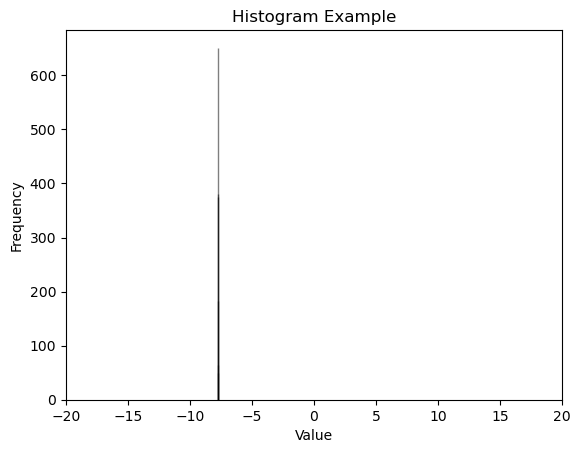

In [29]:
df = pd.read_parquet(os.path.join(o_path, files[200]))
#print(df.iloc[100])
import matplotlib.pyplot as plt
# Create a histogram
plt.hist(df['slope'], bins=100, edgecolor='k', alpha=0.5)  # You can adjust the number of bins as needed
# Add labels and a title
plt.xlim(-20,20)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram Example')
# Show the plot
plt.show()
#df[df.isna().any(axis=1)]

In [30]:
# check same beam, same rgt, same time, slope difference 
df

,land_segments/rgt,land_segments/segment_id_beg,land_segments/segment_id_end,root_beam,root_file,land_segments/canopy/h_canopy_20m,land_segments/latitude,land_segments/longitude,land_segments/latitude_20m,land_segments/longitude_20m,land_segments/delta_time,geometry,slope
h3_12,,,,,,,,,,,,,
8c2a323136a67ff,202,235612,235616,gt2r,ATL08_20230102183624_02021802_006_01.h5,20.470078,42.452904,-72.206207,42.452545,-72.206161,1.579200e+08,b'\x01\x01\x00\x00\x00\x00\x00\x00\xc01\rR\xc0...,-7.736158
8c2a3231379abff,202,235617,235621,gt2r,ATL08_20230102183624_02021802_006_01.h5,28.816559,42.453804,-72.206322,42.453445,-72.206276,1.579200e+08,b'\x01\x01\x00\x00\x00\x00\x00\x00\xa03\rR\xc0...,-7.736158
8c2a323acb681ff,202,235620,235624,gt2l,ATL08_20230102183624_02021802_006_01.h5,14.587692,42.454262,-72.207489,42.453903,-72.207443,1.579200e+08,b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0F\rR\xc0...,-7.747986
8c2a323137939ff,202,235622,235626,gt2r,ATL08_20230102183624_02021802_006_01.h5,29.222870,42.454700,-72.206444,42.454342,-72.206390,1.579200e+08,"b""\x01\x01\x00\x00\x00\x00\x00\x00\x805\rR\xc0...",-7.736158
8c2a323acb61dff,202,235625,235629,gt2l,ATL08_20230102183624_02021802_006_01.h5,13.046310,42.455162,-72.207603,42.454803,-72.207558,1.579200e+08,b'\x01\x01\x00\x00\x00\x00\x00\x00\xa0H\rR\xc0...,-7.747986
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8c2a3205901c3ff,202,236062,236066,gt1l,ATL08_20230102183624_02021802_006_01.h5,1.310959,42.530880,-72.256676,42.531239,-72.256721,1.579200e+08,b'\x01\x01\x00\x00\x00\x00\x00\x00 n\x10R\xc0\...,-7.751286
8c2a320590003ff,202,236064,236068,gt1r,ATL08_20230102183624_02021802_006_01.h5,28.886154,42.531319,-72.255646,42.531677,-72.255692,1.579200e+08,b'\x01\x01\x00\x00\x00\x00\x00\x00@]\x10R\xc0\...,-7.756039
8c2a320590311ff,202,236069,236073,gt1r,ATL08_20230102183624_02021802_006_01.h5,17.767700,42.532215,-72.255768,42.532574,-72.255814,1.579200e+08,b'\x01\x01\x00\x00\x00\x00\x00\x00@_\x10R\xc0\...,-7.756039


In [32]:
import folium
f= 'ATL08_20230102183624_02021802_006_01.h5'
check = df[ (df['root_file'] == f )&  (df['root_beam'] == 'gt1r')]
#check = df[df['land_segments/rgt'] == 775]
# ATL08_20210114193358_03331006_006_01.h5 gt2l
#print(check['land_segments/latitude'][0])
# Create a map centered around a specific location
m = folium.Map(location=[check['land_segments/latitude'][0], check['land_segments/longitude'][0]],  zoom_start = 15)#, max_zoom = 21)
tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
       ).add_to(m)
# Add markers for each set of coordinates
for index, row in check.iterrows():
    folium.Marker(location=[row['land_segments/latitude'], row['land_segments/longitude']]).add_to(m)
m

In [307]:
import time
import os
import subprocess
import multiprocessing
from tqdm import tqdm
nCPU = len(files)
if nCPU > 20 : 
    nCPU = 20  # number of cores to use
#nCPU =  args.n_workers
pool = multiprocessing.Pool(nCPU) # Set up multi-processing
progress_bar = tqdm(total=len(files))
def update_progress_bar(_):
    progress_bar.update()        
for file in files:
    pool.apply_async(add_slope, (file,o_path), callback=update_progress_bar)
pool.close()
pool.join()
# Close the progress bar
progress_bar.close()

100%|███████████████████████████| 349/349 [03:35<00:00,  1.62it/s]


In [120]:
## loop through all files , get slope
# for idx, file in enumerate(files, start=1):
#     print(f"File {idx}: {file}")
#     add_slope (file, o_path)

In [34]:
check.iloc[1]

land_segments/rgt                                                                  202
land_segments/segment_id_beg                                                    235564
land_segments/segment_id_end                                                    235568
root_beam                                                                         gt1r
root_file                                      ATL08_20230102183624_02021802_006_01.h5
land_segments/canopy/h_canopy_20m                                            24.932724
land_segments/latitude                                                       42.441517
land_segments/longitude                                                      -72.24398
land_segments/latitude_20m                                                   42.441158
land_segments/longitude_20m                                                 -72.243927
land_segments/delta_time                                              157920025.258477
geometry                             b'\x01

In [12]:
check.columns.values

array(['land_segments/rgt', 'land_segments/segment_id_beg',
       'land_segments/segment_id_end', 'root_beam', 'root_file',
       'land_segments/canopy/h_canopy_20m_000',
       'land_segments/canopy/h_canopy_20m_001',
       'land_segments/canopy/h_canopy_20m_002',
       'land_segments/canopy/h_canopy_20m_003',
       'land_segments/canopy/h_canopy_20m_004', 'h3_12_20m_000',
       'h3_12_20m_001', 'h3_12_20m_002', 'h3_12_20m_003', 'h3_12_20m_004',
       'land_segments/latitude', 'land_segments/longitude',
       'land_segments/latitude_20m_000', 'land_segments/latitude_20m_001',
       'land_segments/latitude_20m_002', 'land_segments/latitude_20m_003',
       'land_segments/latitude_20m_004',
       'land_segments/longitude_20m_000',
       'land_segments/longitude_20m_001',
       'land_segments/longitude_20m_002',
       'land_segments/longitude_20m_003',
       'land_segments/longitude_20m_004', 'land_segments/delta_time',
       'geometry', 'slope'], dtype=object)

In [ ]:
# all files saved in tmp folder
# now merge into 20m segment
# /gpfs/data1/vclgp/xiongl/ProjectIS2CalVal/tmp
